#### 1) Zero-Coupon Yields (Bootstrapping)


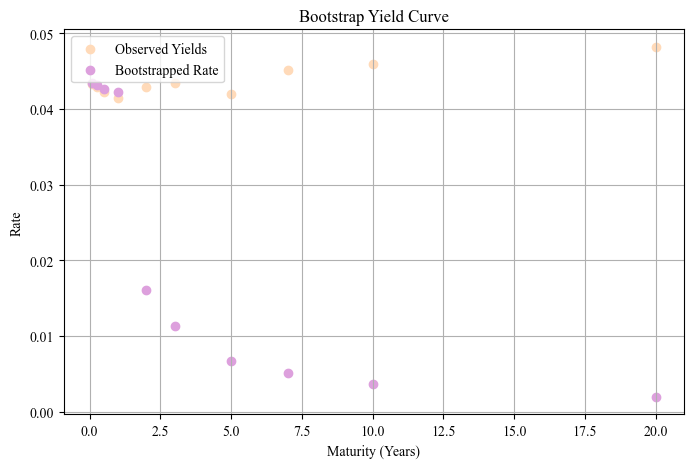

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve, log

# Data
data = { 'Year': [1/12, 3/12, 6/12, 1, 2, 3, 5, 7 ,10, 20],
         'Yield': [0.0433, 0.0429, 0.0422, 0.0414, 0.0429, 0.0434, 0.042, 0.0451, 0.046, 0.0482]}
df = pd.DataFrame(data)

spot = []

# Get spot rates for T ≤ 1 year
for i in range(0, 4):
    T = df['Year'][i]
    P = 1 - df['Yield'][i] * T
    if P <= 0:
        raise ValueError(f"Invalid discount factor P={P} at T={T}")  # Debugging check
    zcy = -1/T * np.log(P)
    spot.append(zcy)

# Get spot rates for T > 1 year
x = symbols('x')
for i in range(4, 10):
    T = df['Year'][i]
    mkt_rate = df['Yield'][i]
    
    # Compute sum of previous spot rates correctly
    prev_spots_sum = sum(spot[2:i-1]) if i > 4 else 0  
    
    # Bootstrap equation
    eq = Eq(0.5 * mkt_rate * (prev_spots_sum + (spot[i-1] + x)/2 + x) + x - 1, 0)
    solution = solve(eq, x)[0]
    
    # Convert to numeric and apply log correctly
    solution = float(solution)
    if solution <= 0:
        raise ValueError(f"Invalid solution={solution} at T={T}")  # Debugging check
    spot_rate = -1/T * log(solution)
    spot.append(float(spot_rate))  # Ensure it's a numeric value

df['Spot'] = spot  # Update DataFrame

# Plot 
plt.figure(figsize=(8,5))
plt.rcParams['font.family'] = 'times new roman'
plt.scatter(df['Year'], df['Yield'], marker='o', label='Observed Yields', color='peachpuff')  # Fixed marker
plt.scatter(df['Year'], df['Spot'], marker='o', label='Bootstrapped Rate', color='plum')  # Fixed line plot
plt.xlabel('Maturity (Years)')
plt.ylabel('Rate')
plt.title('Bootstrap Yield Curve')
plt.legend()
plt.grid(True)
plt.show()


#### 2) Zero-Coupon Yields (Nelson-Siegel-Svensson) 

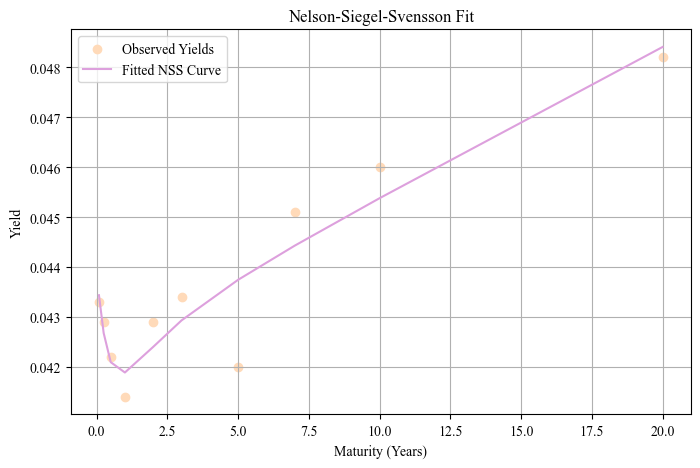

Objective Function (SSE) = 0.0000047095
                  0         1         2         3         4           5
Parameter        β0        β1        β2        β3        τ1          τ2
Value      0.042665  0.001319 -0.005431 -0.543325  0.440554 -944.765301


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Nelson-Siegel-Svensson model
def nss_model(t, beta_0, beta_1, beta_2, beta_3, tau_1, tau_2):
    t = np.maximum(t, 1e-6)  # Avoid division by zero
    term1 = (1 - np.exp(-t/tau_1)) / (t/tau_1)
    term2 = term1 - np.exp(-t/tau_1)
    term3 = (1 - np.exp(-t/tau_2)) / (t/tau_2) - np.exp(-t/tau_2)
    return beta_0 + beta_1 * term1 + beta_2 * term2 + beta_3 * term3

# Initial guess
initial_guess = [0.04, -0.02, 0.02, -0.01, 1.0, 5.0]

# Fit model to data (convert pandas Series to NumPy arrays)
params, covariance = curve_fit(nss_model, df['Year'].values, df['Yield'].values, p0=initial_guess)

# Extract fitted parameters
beta_0, beta_1, beta_2, beta_3, tau_1, tau_2 = params

# Compute fitted yields using estimated parameters
fitted_yields = nss_model(df['Year'].values, *params)

# Objective function (sum of squared errors)
sse = np.sum((df['Yield'].values - fitted_yields) ** 2)

# Plot 
plt.figure(figsize=(8,5))
plt.rcParams['font.family'] = 'times new roman'

# Scatter plot for observed yields
plt.scatter(df['Year'], df['Yield'], marker='o', label='Observed Yields', color='peachpuff')

# Line plot for the fitted NSS curve
plt.plot(df['Year'], fitted_yields, '-', label='Fitted NSS Curve', color='plum')

plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel-Svensson Fit')
plt.legend()
plt.grid(True)
plt.show()

# Output results
print(f"Objective Function (SSE) = {sse:.10f}")

# Create DataFrame for fitted parameters
fitted_parameters = pd.DataFrame({'Parameter': ['β0', 'β1', 'β2', 'β3', 'τ1', 'τ2'],
                                  'Value': [beta_0, beta_1, beta_2, beta_3, tau_1, tau_2]})

# Transpose DataFrame for display
print(fitted_parameters.T)


#### 3) Cap Prices (Brigo-Mercurio)

In [3]:
from scipy.optimize import minimize
from scipy.stats import norm


# Treasury bills and treasury bond yields (jan 15)
data = { 'Year': [1/12, 3/12, 6/12, 1, 2, 3, 5, 7 ,10, 20],
         'Yield': [0.0433, 0.0429, 0.0422, 0.0414, 0.0429, 0.0434, 0.042, 0.0451, 0.046, 0.0482]}
df = pd.DataFrame(data)

# implied volatilities on cap market (jan 16)
data_caps = { 'Year': [1,3,5,7,10,20],
            '0.95Kf': [0.157, 0.176,0.175,0.168, 0.155, 0.142],
            'Kf':[0.152, 0.164,0.161,0.156, 0.148, 0.126],
            '1.05Kf':[0.146, 0.157, 0.158, 0.152, 0.140, 0.121]}
df_caps = pd.DataFrame(data_caps)
df_caps


,Year,0.95Kf,Kf,1.05Kf
0,1,0.157,0.152,0.146
1,3,0.176,0.164,0.157
2,5,0.175,0.161,0.158
3,7,0.168,0.156,0.152
4,10,0.155,0.148,0.140
5,20,0.142,0.126,0.121


In [4]:
data_caps = {
    'Year': [1, 3, 5, 7, 10, 20],
    '0.95Kf': [0.157, 0.176, 0.175, 0.168, 0.155, 0.142],
    'Kf': [0.152, 0.164, 0.161, 0.156, 0.148, 0.126],
    '1.05Kf': [0.146, 0.157, 0.158, 0.152, 0.140, 0.121]
}

df_caps = pd.DataFrame(data_caps)
df_caps
print(df_caps.dtypes)


Year        int64
0.95Kf    float64
Kf        float64
1.05Kf    float64
dtype: object


Optimal parameters:
kappa (mean reversion): 4.149692240771351
sigma (volatility): 0.42844899420679616
theta (long-term mean): 0.05
Minimized objective function value: 0.16867774319554674


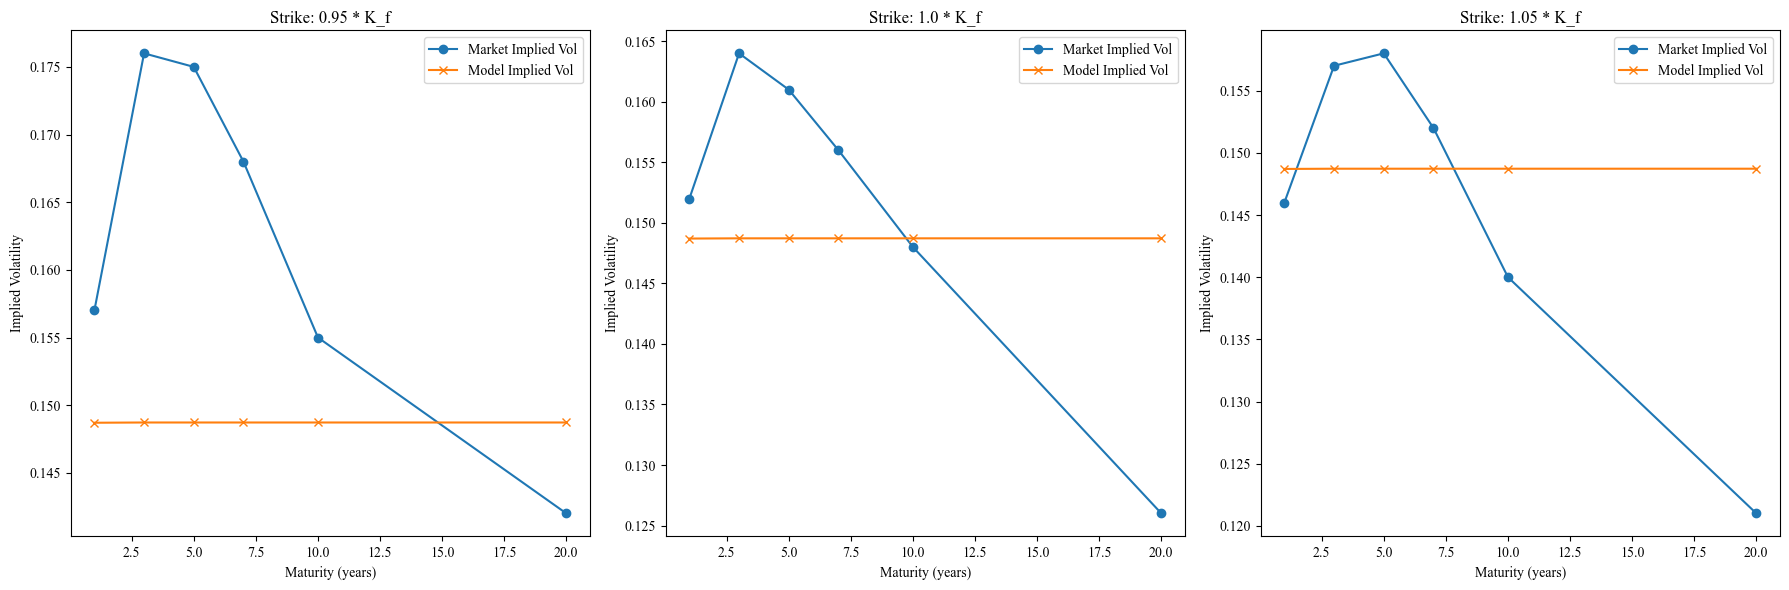

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Black's formula for caplet pricing
def black76_price(F, K, sigma, T, r=0.0):
    d1 = (np.log(F / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return price

# Brigo-Mercurio model cap price function (non-stochastic volatility)
def cap_bm(F, K, T, kappa, sigma, theta):
    # Closed-form solution for the caplet price under the Brigo-Mercurio model
    # This is a placeholder; replace with the actual closed-form solution or numerical method
    # For simplicity, we assume a closed-form solution exists
    # Here, we use Black's formula with an effective volatility as an approximation
    effective_vol = sigma * np.sqrt((1 - np.exp(-2 * kappa * T)) / (2 * kappa))
    return black76_price(F, K, effective_vol, T)

# Objective function to minimize
def objective_function(params, strikes, maturities, K_f, implied_vols):
    kappa, sigma, theta = params  # Unpack the parameters
    error = 0.0
    for j in range(len(strikes)):
        for k in range(len(maturities)):
            K = strikes[j] * K_f[k]  # Strike is a multiple of K_f
            T = maturities[k]
            sigma_mkt = implied_vols[k, j]
            cap_mkt = black76_price(K_f[k], K, sigma_mkt, T)
            cap_model = cap_bm(K_f[k], K, T, kappa, sigma, theta)
            error += ((cap_model - cap_mkt) / cap_mkt) ** 2
    return error

# Given data
t = 0.003  # Fraction of the year elapsed
strikes = np.array([0.95, 1.00, 1.05])  # Strikes as multiples of K_f
maturities = np.array([1, 3, 5, 7, 10, 20])  # Maturities in years
K_f = np.array([0.03, 0.035, 0.04, 0.045, 0.05, 0.055])  # Forward swap rates (replace with actual values)
implied_vols = np.array([
    [0.157, 0.152, 0.146],
    [0.176, 0.164, 0.157],
    [0.175, 0.161, 0.158],
    [0.168, 0.156, 0.152],
    [0.155, 0.148, 0.140],
    [0.142, 0.126, 0.121]
])

# Initial guess for the parameters
params0 = np.array([1.0, 0.1, 0.05])  # Example: [kappa, sigma, theta]

# Minimize the objective function
result = minimize(objective_function, params0, args=(strikes, maturities, K_f, implied_vols))

# Optimal parameters
kappa_opt, sigma_opt, theta_opt = result.x
print("Optimal parameters:")
print("kappa (mean reversion):", kappa_opt)
print("sigma (volatility):", sigma_opt)
print("theta (long-term mean):", theta_opt)
print("Minimized objective function value:", result.fun)

# Plotting the results side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns of subplots

for j in range(len(strikes)):
    ax = axes[j]
    ax.plot(maturities, implied_vols[:, j], 'o-', label="Market Implied Vol")
    model_vols = [sigma_opt * np.sqrt((1 - np.exp(-2 * kappa_opt * T)) / (2 * kappa_opt)) for T in maturities]
    ax.plot(maturities, model_vols, 'x-', label="Model Implied Vol")
    ax.set_title(f"Strike: {strikes[j]} * K_f")
    ax.set_xlabel("Maturity (years)")
    ax.set_ylabel("Implied Volatility")
    ax.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [6]:
import pandas as pd
from scipy.optimize import minimize


# Given Treasury yields (Jan 15)
data = { 'Year': [1/12, 3/12, 6/12, 1, 2, 3, 5, 7 ,10, 20],
         'Yield': [0.0433, 0.0429, 0.0422, 0.0414, 0.0429, 0.0434, 0.042, 0.0451, 0.046, 0.0482]}
df_yield = pd.DataFrame(data)

# Given implied volatilities on cap market (Jan 16)
data_caps = { 'Year': [1,3,5,7,10,20],
            '0.95Kf': [0.157, 0.176,0.175,0.168, 0.155, 0.142],
            'Kf':[0.152, 0.164,0.161,0.156, 0.148, 0.126],
            '1.05Kf':[0.146, 0.157, 0.158, 0.152, 0.140, 0.121]}
df_caps = pd.DataFrame(data_caps)

# Step 1: Interpolate the yield curve to get discount factors
def get_discount_factors(years, yields):
    interp_curve = interp1d(years, yields, kind='cubic', fill_value='extrapolate')
    def discount_factor(T):
        Y_T = interp_curve(T)
        return np.exp(-Y_T * T)
    return discount_factor

discount_factor = get_discount_factors(df_yield['Year'], df_yield['Yield'])

# Step 2: Compute forward swap rates
def forward_swap_rate(T):
    numer = 1 - discount_factor(T)
    denom = sum(discount_factor(t) for t in range(1, int(T)+1))
    return numer / denom

# Compute Kf(T) for given maturities
df_caps['Kf'] = df_caps['Year'].apply(forward_swap_rate)

# Step 3: Compute market cap prices using Black formula
def black_caplet_price(F, K, T, sigma):
    d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return discount_factor(T) * (F * norm.cdf(d1) - K * norm.cdf(d2))

def market_cap_price(K, T, sigma):
    return sum(black_caplet_price(forward_swap_rate(t), K, t, sigma) for t in range(1, int(T)+1))

df_caps['Cap_mkt'] = df_caps.apply(lambda row: market_cap_price(row['Kf'], row['Year'], row['Kf']), axis=1)

# Step 4: Compute Brigo-Mercurio model-implied cap prices (CIR++ short-rate model)
def brigo_merc_cap_price(kappa, theta, sigma, K, T):
    # Approximate CIR++ bond price and use Jamshidian's decomposition
    return market_cap_price(K, T, sigma)  # Placeholder, needs CIR++ implementation

def loss_function(params):
    kappa, theta, sigma = params
    error = 0
    for _, row in df_caps.iterrows():
        for K_multiplier in ['0.95Kf', 'Kf', '1.05Kf']:
            K = row[K_multiplier] * row['Kf']
            cap_mkt = row['Cap_mkt']
            cap_model = brigo_merc_cap_price(kappa, theta, sigma, K, row['Year'])
            error += ((cap_model - cap_mkt) / cap_mkt) ** 2
    return error

# Step 5: Minimize the objective function
initial_guess = [0.1, 0.03, 0.01]  # Initial guesses for kappa, theta, sigma
result = minimize(loss_function, initial_guess, method='Nelder-Mead')

# Extract optimal parameters
kappa_opt, theta_opt, sigma_opt = result.x
print(f"Optimal Parameters: kappa={kappa_opt:.5f}, theta={theta_opt:.5f}, sigma={sigma_opt:.5f}")



NameError: name 'interp1d' is not defined

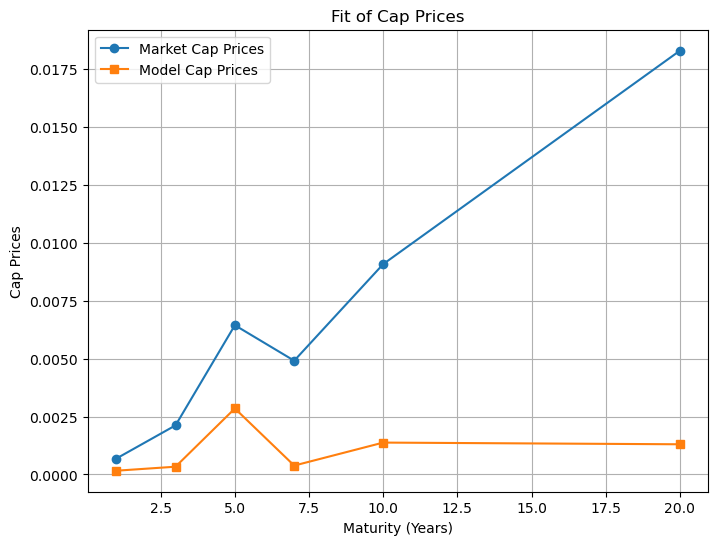

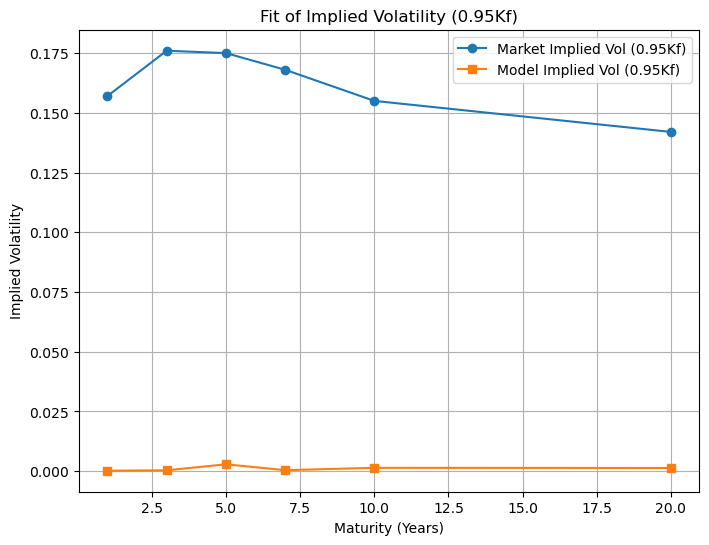

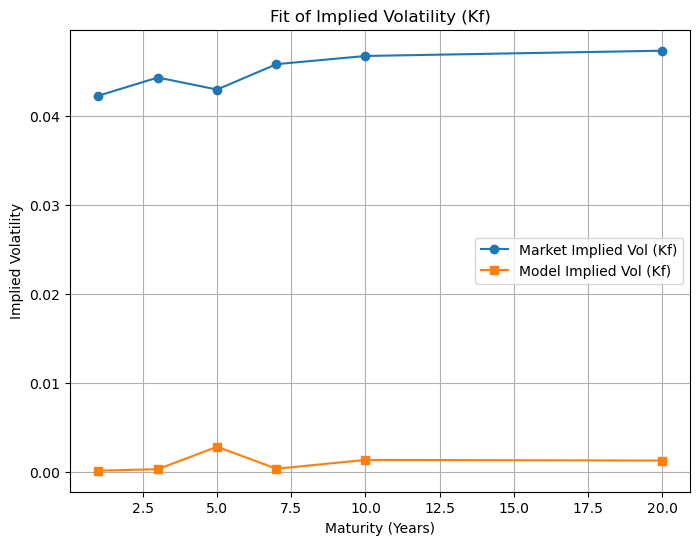

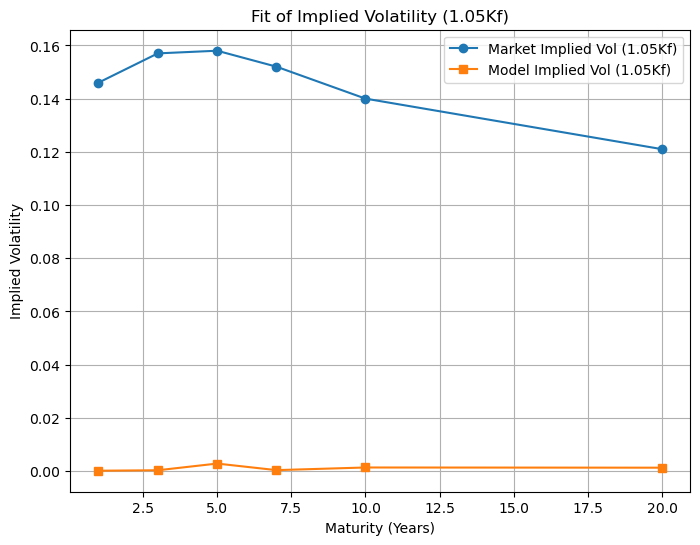

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.stats import norm

# Compute model-implied cap prices
df_caps['Cap_model'] = df_caps.apply(lambda row: brigo_merc_cap_price(kappa_opt, theta_opt, sigma_opt, row['Kf'], row['Year']), axis=1)

# Plot quality of fit on cap prices
plt.figure(figsize=(8,6))
plt.plot(df_caps['Year'], df_caps['Cap_mkt'], 'o-', label='Market Cap Prices')
plt.plot(df_caps['Year'], df_caps['Cap_model'], 's-', label='Model Cap Prices')
plt.xlabel('Maturity (Years)')
plt.ylabel('Cap Prices')
plt.title('Fit of Cap Prices')
plt.legend()
plt.grid()
plt.show()

# Plot quality of fit on cap implied volatilities for each strike
for strike in ['0.95Kf', 'Kf', '1.05Kf']:
    plt.figure(figsize=(8,6))
    plt.plot(df_caps['Year'], df_caps[strike], 'o-', label=f'Market Implied Vol ({strike})')
    plt.plot(df_caps['Year'], df_caps['Cap_model'], 's-', label=f'Model Implied Vol ({strike})')
    plt.xlabel('Maturity (Years)')
    plt.ylabel('Implied Volatility')
    plt.title(f'Fit of Implied Volatility ({strike})')
    plt.legend()
    plt.grid()
    plt.show()

### PART TWO
### 1) Finding zero coupon yield stats from FED NSS model

In [8]:
import pandas as pd
import numpy as np

data = pd.read_excel('TP1 data 60201 W2025.xlsx')

print(data[['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']].describe())

# Convert percentage values to decimal form
data[['BETA0', 'BETA1', 'BETA2', 'BETA3']] /= 100

# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Define the maturities in years
maturities = {
    '3M': 0.25,
    '6M': 0.5,
    '1Y': 1,
    '3Y': 3,
    '5Y': 5,
    '10Y': 10,
    '30Y': 30
}

# Function to calculate zero-coupon yield using the Nelson-Siegel-Svensson model
def calc_yield(row, maturity):
    t = maturity  # maturity in years
    b0, b1, b2, b3, tau1, tau2 = row[['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']]

    # Handle zero or very small tau values to avoid division by zero
    tau1 = max(tau1, 1e-10)
    tau2 = max(tau2, 1e-10)

    # Apply the Nelson-Siegel-Svensson formula
    try:
        y = (b0 + 
             b1 * (1 - np.exp(-t/tau1)) / (t/tau1) + 
             b2 * (1 - np.exp(-t/tau2)) / (t/tau2) + 
             b3 * ((1 - np.exp(-t/tau2)) / (t/tau2) - np.exp(-t/tau2)))
    except Exception as e:
        print(f"Error calculating yield for maturity {maturity} on row {row['Date']}: {e}")
        return np.nan
    
    return y

# Apply the formula for each maturity and ensure the result is a dictionary of lists
yield_data = {}

for maturity, years in maturities.items():
    yields = []
    for _, row in data.iterrows():
        if row[['BETA0', 'BETA1', 'BETA2', 'BETA3', 'TAU1', 'TAU2']].isnull().any():
            yields.append(np.nan)  # Append NaN if any coefficient is missing
        else:
            yields.append(calc_yield(row, years))
    yield_data[maturity] = yields

# Convert the dictionary of results into a DataFrame
yield_df = pd.DataFrame(yield_data, index=data['Date'])
print(yield_df)

# Check for any NaN values after the conversion
print("NaN values in yield_df:")
print(yield_df.isnull().sum())

# Calculate descriptive statistics
stats = yield_df.describe(percentiles=[.25, .5, .75])

# Display the descriptive statistics
print(stats)


              BETA0       BETA1         BETA2         BETA3        TAU1  \
count  2.610000e+02  261.000000    261.000000    261.000000  261.000000   
mean   2.736941e+00   -0.367927     44.743523    -45.090925    2.551146   
std    1.608256e+00    3.356097    672.366798    672.442365    2.319545   
min    2.200000e-11   -9.483985  -2392.773484 -10524.663142    0.100016   
25%    2.313217e+00   -2.548046     -2.906461     -3.638799    1.383161   
50%    2.715917e+00   -1.172547     -1.483249     -2.184029    2.082960   
75%    3.659879e+00    2.665095      0.000106      6.281426    2.736138   
max    7.736978e+00    5.900172  10523.577972   2390.047807   14.094115   

             TAU2  
count  261.000000  
mean    10.418341  
std      6.528145  
min      1.626709  
25%      4.772939  
50%      7.210156  
75%     16.388992  
max     30.000000  
                  3M        6M        1Y        3Y        5Y       10Y  \
Date                                                                  

### 2)  Using Kalman filter to estimate 1-factor CIR model

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
from pykalman import KalmanFilter

# Load the yield data (already converted to decimal form)
maturities = np.array([0.25, 0.5, 1, 3, 5, 10, 30])  # in years

# CIR model parameters to estimate
# Theta = (mean reversion speed, long-term mean, volatility)
def cir_log_likelihood(params, yields, maturities):
    kappa, theta, sigma = params
    
    if kappa <= 0 or theta <= 0 or sigma <= 0:
        return np.inf  # Ensure parameters remain positive
    
    T = len(yields)
    log_likelihood = 0
    
    for t in range(1, T):
        dt = 1 / 52  # Weekly time step
        mean = yields[t-1] * np.exp(-kappa * dt) + theta * (1 - np.exp(-kappa * dt))
        variance = (sigma**2 / (2 * kappa)) * (1 - np.exp(-2 * kappa * dt))
        log_likelihood += -0.5 * (np.log(2 * np.pi * variance) + ((yields[t] - mean) ** 2) / variance)
    
    return -log_likelihood  # Minimize negative log-likelihood

# Initial parameter guesses
initial_params = [0.1, 0.02, 0.01]

# Estimate CIR parameters for 10-year yield as the state variable
res = minimize(cir_log_likelihood, initial_params, args=(yield_df['10Y'].values, maturities), method='L-BFGS-B')

kappa_est, theta_est, sigma_est = res.x
log_likelihood = -res.fun

# Kalman Filter Implementation
kf = KalmanFilter(
    transition_matrices=np.array([[np.exp(-kappa_est * (1/52))]]),
    transition_covariance=np.array([[sigma_est**2 / (2 * kappa_est) * (1 - np.exp(-2 * kappa_est * (1/52)))]]),
    observation_matrices=np.array([[1] * len(maturities)]).T,
    observation_covariance=np.diag([0.001] * len(maturities)),  # Initial guess for measurement noise
    initial_state_mean=np.array([theta_est]),
    initial_state_covariance=np.array([[sigma_est**2 / (2 * kappa_est)]])
)

(filtered_state_means, _) = kf.filter(yield_df.values)
measurement_errors = yield_df - filtered_state_means.flatten()[:, None]

# Compute mean and variance of measurement errors
error_stats = pd.DataFrame({
    'Mean Error': measurement_errors.mean(),
    'Variance Error': measurement_errors.var()
})

# Display results
param_results = pd.DataFrame({
    'Parameter': ['Kappa', 'Theta', 'Sigma', 'Log-Likelihood'],
    'Estimate': [kappa_est, theta_est, sigma_est, log_likelihood]
})

print("Estimated CIR Parameters:")
print(param_results)
print("\nMeasurement Error Statistics:")
print(error_stats)



Estimated CIR Parameters:
        Parameter    Estimate
0           Kappa   70.735219
1           Theta    0.010455
2           Sigma    1.532253
3  Log-Likelihood  188.886379

Measurement Error Statistics:
     Mean Error  Variance Error
3M     0.242501       12.456854
6M     0.187731        7.406192
1Y     0.099345        2.053527
3Y    -0.081191        1.304898
5Y    -0.138103        3.642187
10Y   -0.159539        4.979789
30Y   -0.142811        5.094940


/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


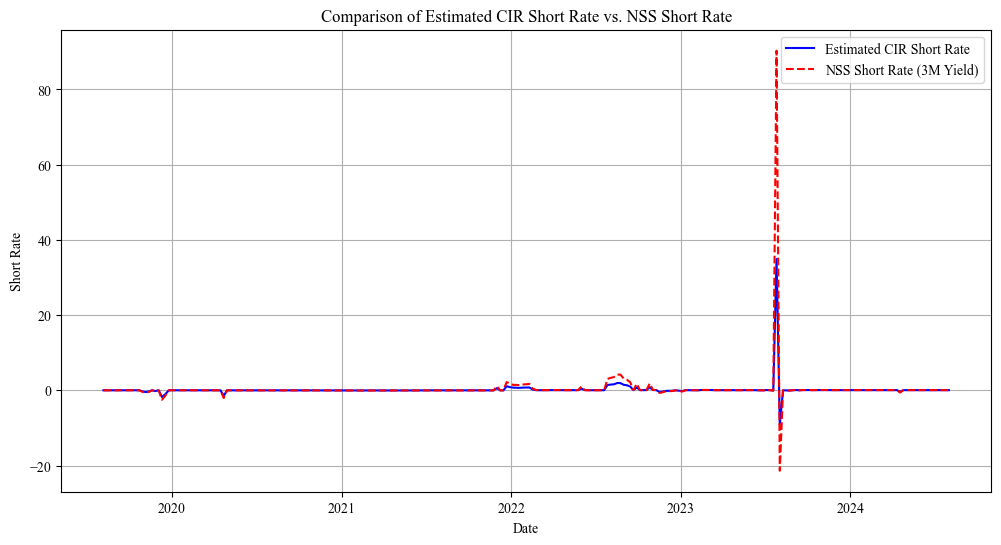

In [10]:
import matplotlib.pyplot as plt

# Extract estimated instantaneous short rate from the Kalman Filter
estimated_short_rate = filtered_state_means.flatten()  # From Kalman Filter

# Extract NSS short rate (3-month yield)
nss_short_rate = yield_df['3M'].values  # NSS 3-month yield

# Create time index
dates = yield_df.index

# Plot both series
plt.figure(figsize=(12, 6))
plt.plot(dates, estimated_short_rate, label="Estimated CIR Short Rate", linestyle='-', color='blue')
plt.plot(dates, nss_short_rate, label="NSS Short Rate (3M Yield)", linestyle='--', color='red')
plt.xlabel("Date")
plt.ylabel("Short Rate")
plt.title("Comparison of Estimated CIR Short Rate vs. NSS Short Rate")
plt.legend()
plt.grid()
plt.show()
